In [ ]:
import os
import shutil
import PIL
import itertools

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ipywidgets as widgets
from IPython.display import Image, display, clear_output

In [ ]:
from importlib import reload

# import .py files
import out_of_the_loop
import sampling

# reload modules
reload(out_of_the_loop)
reload(sampling)

# import classes and functions
from out_of_the_loop import GaussianProcess, BayesianOptimization, RandomGridSearch
from sampling import Metropolis

## Objective function

In [ ]:
def obj_func_1D(x, a=1.4, b=3, c=18):
    return -(a-b*x)*np.sin(c*x)

In [ ]:
np.random.seed(84673762)

# set bounds
x_min, x_max = 0.0, 1.2

# set grid
step = 0.01
x_tot = np.arange(x_min, x_max + step, step)

# observed locations and values
idx = np.random.choice(np.arange(x_tot.shape[0]), size=2, replace=False)
x = x_tot[idx]
y = obj_func_1D(x)

# test locations
xs = np.delete(x_tot, idx)

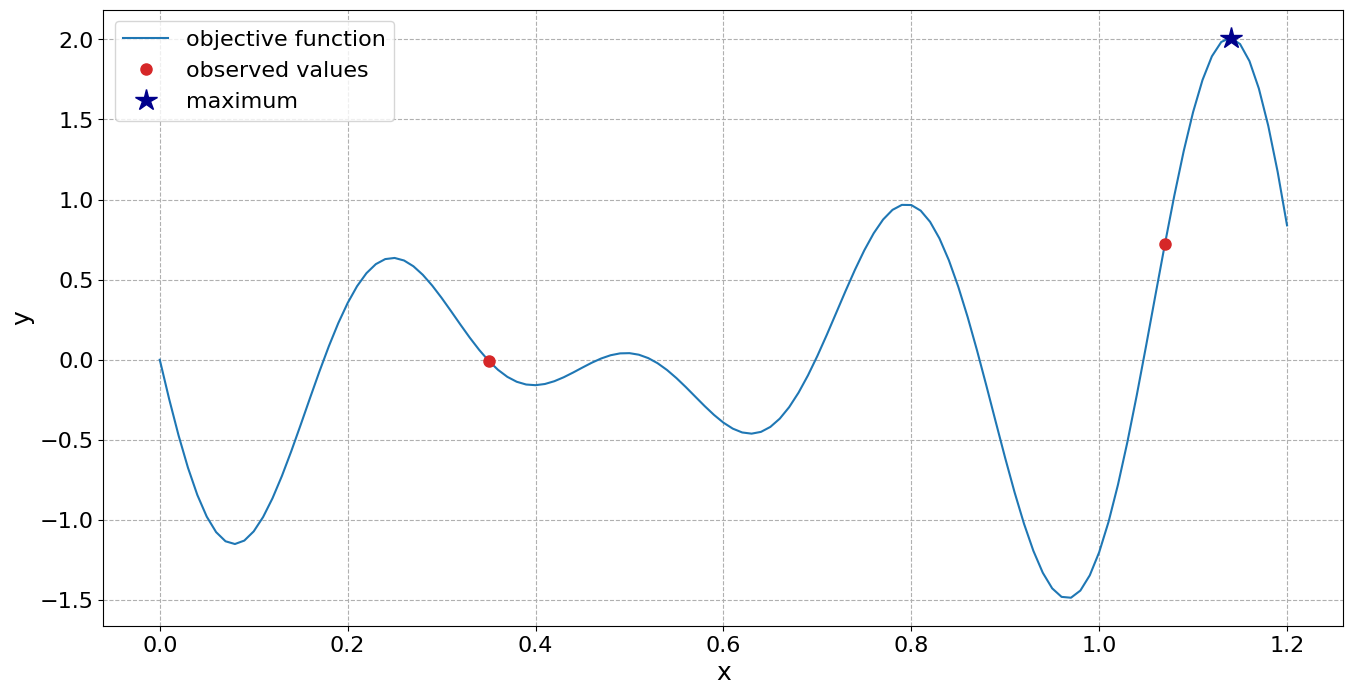

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(x_tot, obj_func_1D(x_tot), color="tab:blue", label="objective function")
plt.plot(x, y, color="tab:red", marker=".", ls="", ms=16, label="observed values")
plt.plot(x_tot[obj_func_1D(x_tot).argmax()], np.max(obj_func_1D(x_tot)), color="darkblue", marker="*", ls="", ms=16, label="maximum")

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.legend(fontsize=16)
plt.grid(ls="--")
plt.show()

## Gaussian process

In [ ]:
# parameters
X = x.reshape(-1,1)
Y = y
Xs = xs.reshape(-1,1)
var = 0
kernel = "matern_5"
theta = np.array([1, 0.1])
#tuning = {"method": "off"}
tuning = {"method": "MLE", "bounds": None}
#tuning = {"method": "GD", "epochs": 100, "lr": 0.001}

In [ ]:
GP = GaussianProcess(X, Y, Xs, var, kernel, theta, tuning)
GP.active_learning()

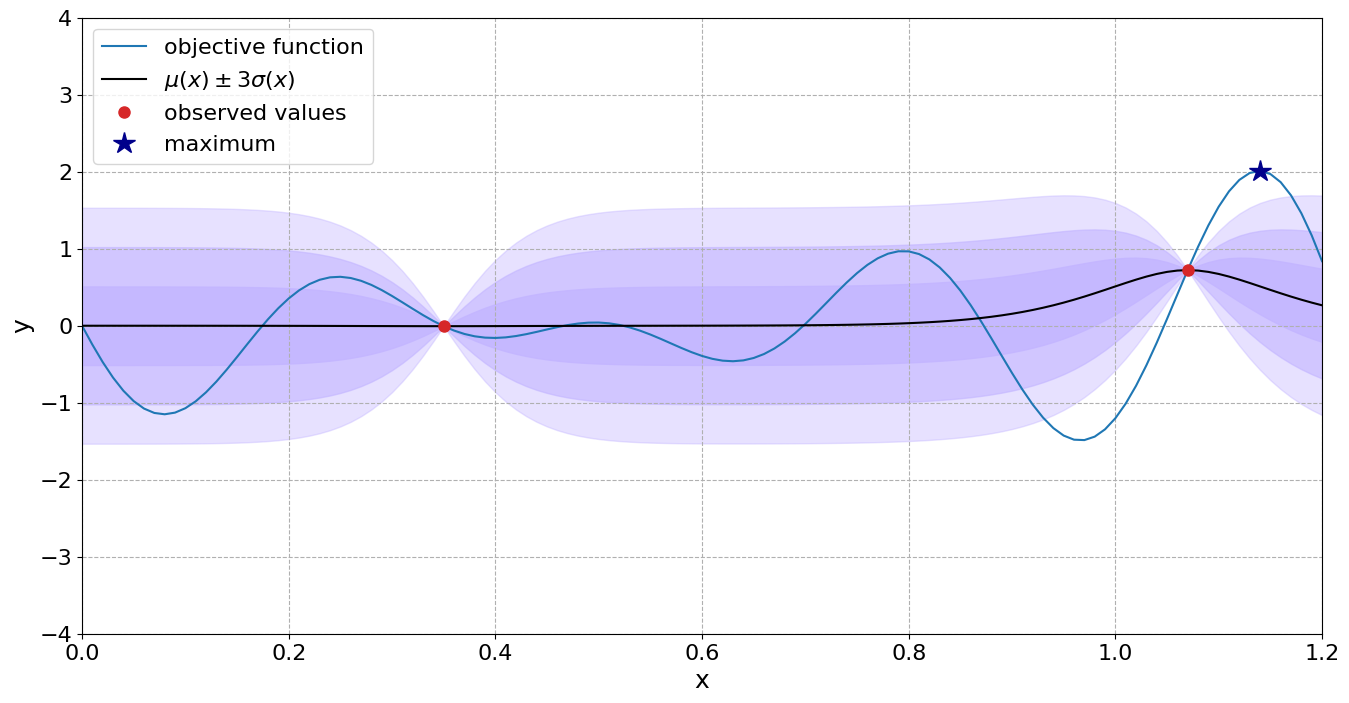

In [ ]:
n_std = 3

# plot
fig = plt.figure(figsize=(16,8))

# objective function, posterior mean and observed points
data = {
    "x": np.append(GP.Xs[:,0], GP.X[:,0]),
    "obj": np.append(obj_func_1D(GP.Xs[:,0]), GP.Y),
    "mu": np.append(GP.mu, GP.Y)
}

df = pd.DataFrame.from_dict(data)
df = df.sort_values("x")

plt.plot(df.x, df.obj, color="tab:blue", label="objective function")
plt.plot(df.x, df.mu, color="k", label=f"$\mu(x) \pm {n_std}\sigma(x)$", zorder=2)
plt.plot(GP.X[:,0], GP.Y, color="tab:red", marker=".", ls="", ms=16, label="observed values")
plt.plot(x_tot[obj_func_1D(x_tot).argmax()], np.max(obj_func_1D(x_tot)), color="darkblue", marker="*", ls="", ms=16, label="maximum")


# posterior covariance matrix
std = np.sqrt(np.diagonal(GP.Sigma))

for n in range(n_std):

    data_std = {
        "x": np.append(GP.Xs[:,0], GP.X[:,0]),
        "low": np.append(GP.mu + (n+1)*std, GP.Y),
        "high": np.append(GP.mu - (n+1)*std, GP.Y)
    }

    df_std = pd.DataFrame.from_dict(data_std)
    df_std = df_std.sort_values("x")
    plt.fill_between(df_std.x, df_std.low, df_std.high, color='#c3b5ff', alpha=1-(n+1)*0.2, zorder=1)

plt.xlim((0, 1.2))
plt.ylim((-4, 4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.legend(fontsize=16)
plt.legend(loc="upper left", fontsize=16)
#plt.legend(loc="center left", fontsize=16, bbox_to_anchor=(1.0, 0.5))
plt.grid(ls="--")

#fig.subplots_adjust(right=0.7)

## Bayesian optimization

In [ ]:
# parameters
acq_func = {"method": "EI", "tradeoff": 0.005}
marginalize_acq = {"status": False}
#marginalize_acq = {"status": True, "num_samples": 2000, "num_burns": 1000, "thinning": 10, "std": 0.1}
n_query = 10

In [ ]:
BO = BayesianOptimization(X, Y, Xs, var, kernel, theta, tuning, obj_func_1D, acq_func, marginalize_acq, n_query)
BO.Bayesian_search()

Bayesian search started ...

Iteration 1/10
- theta: [0.51071937 0.09998448]
- non-positive var: []
- query point: [1.13]

Iteration 2/10
- theta: [ 1.16628446 -0.06031107]
- non-positive var: []
- query point: [1.16]

Iteration 3/10
- theta: [ 1.08737473 -0.08091812]
- non-positive var: []
- query point: [1.14]

Iteration 4/10
- theta: [ 1.08676934 -0.09729657]
- non-positive var: []
- query point: [0.]

Iteration 5/10
- theta: [ 0.94300556 -0.09048667]
- non-positive var: []
- query point: [0.64]

Iteration 6/10
- theta: [ 0.86912287 -0.08698866]
- non-positive var: []
- query point: [0.17]

Iteration 7/10
- theta: [ 0.7995002  -0.08413238]
- non-positive var: []
- query point: [0.85]

Iteration 8/10
- theta: [ 0.7599513  -0.08105348]
- non-positive var: []
- query point: [0.48]

Iteration 9/10
- theta: [ 0.71655404 -0.07968388]
- non-positive var: []
- query point: [1.2]

Iteration 10/10
- theta: [ 0.7022927  -0.07065022]
- non-positive var: []
- query point: [0.94]


## Visualization

In [ ]:
DIR_PATH = "./images_1D"

if os.path.isdir(DIR_PATH):
    # remove directory
    shutil.rmtree(DIR_PATH)
    print("Directory '{}' removed".format(DIR_PATH))

if not os.path.isdir(DIR_PATH):
    # create directory
    os.mkdir(DIR_PATH)
    print("Directory '{}' created".format(DIR_PATH))

Directory './images_1D' removed
Directory './images_1D' created


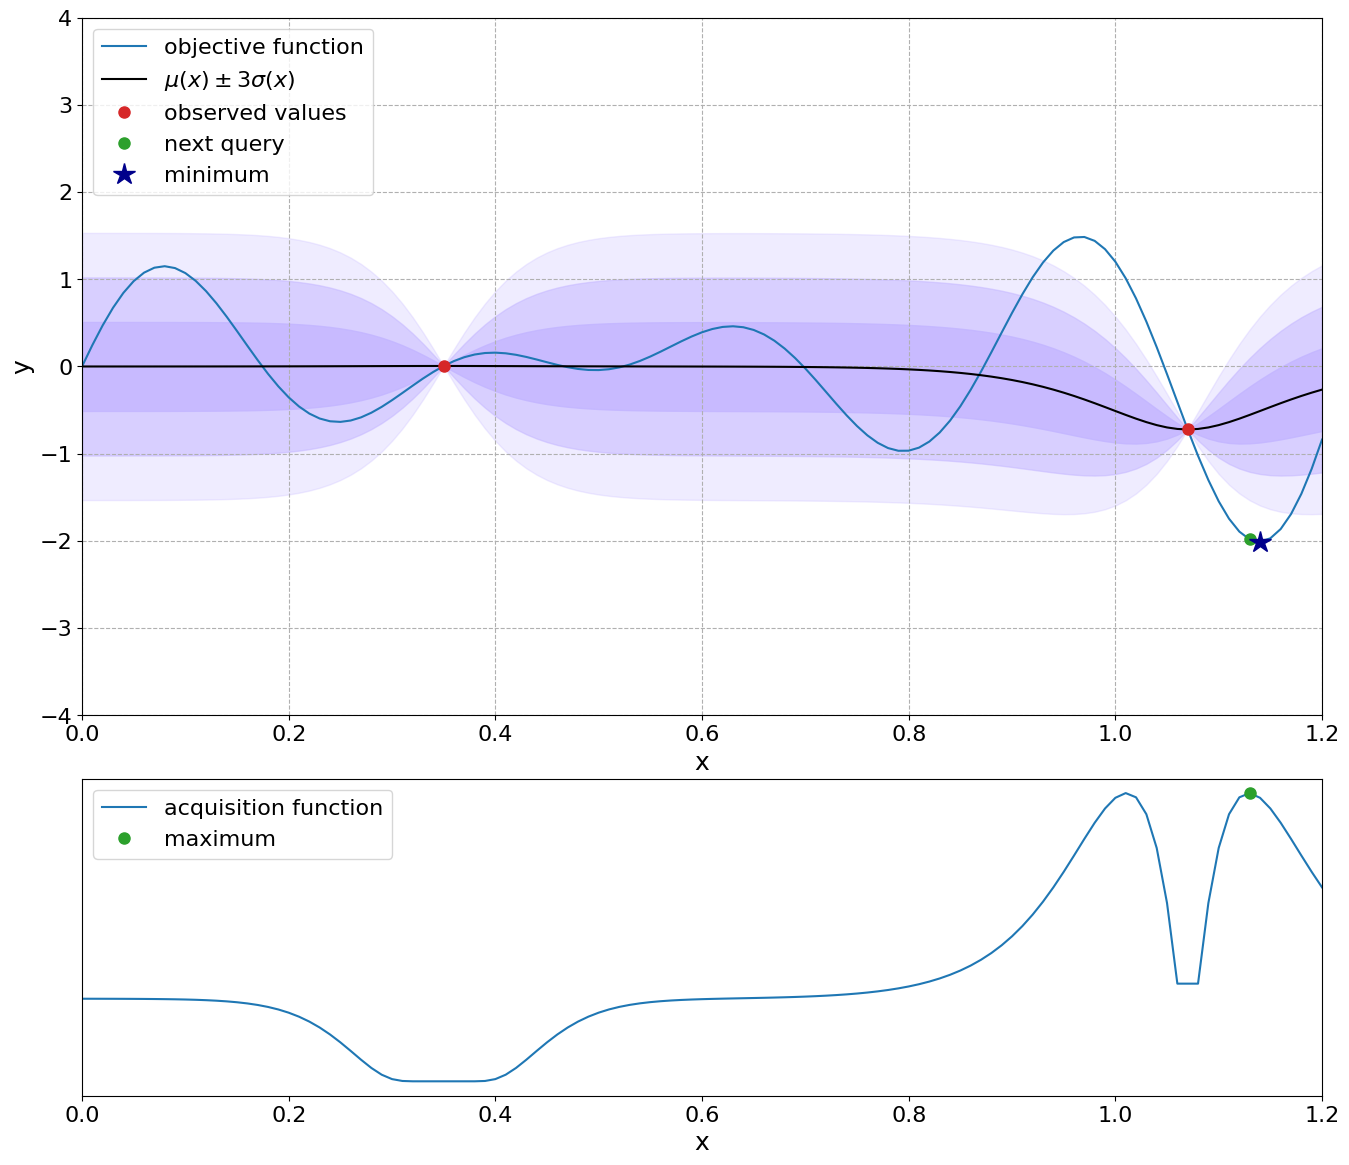

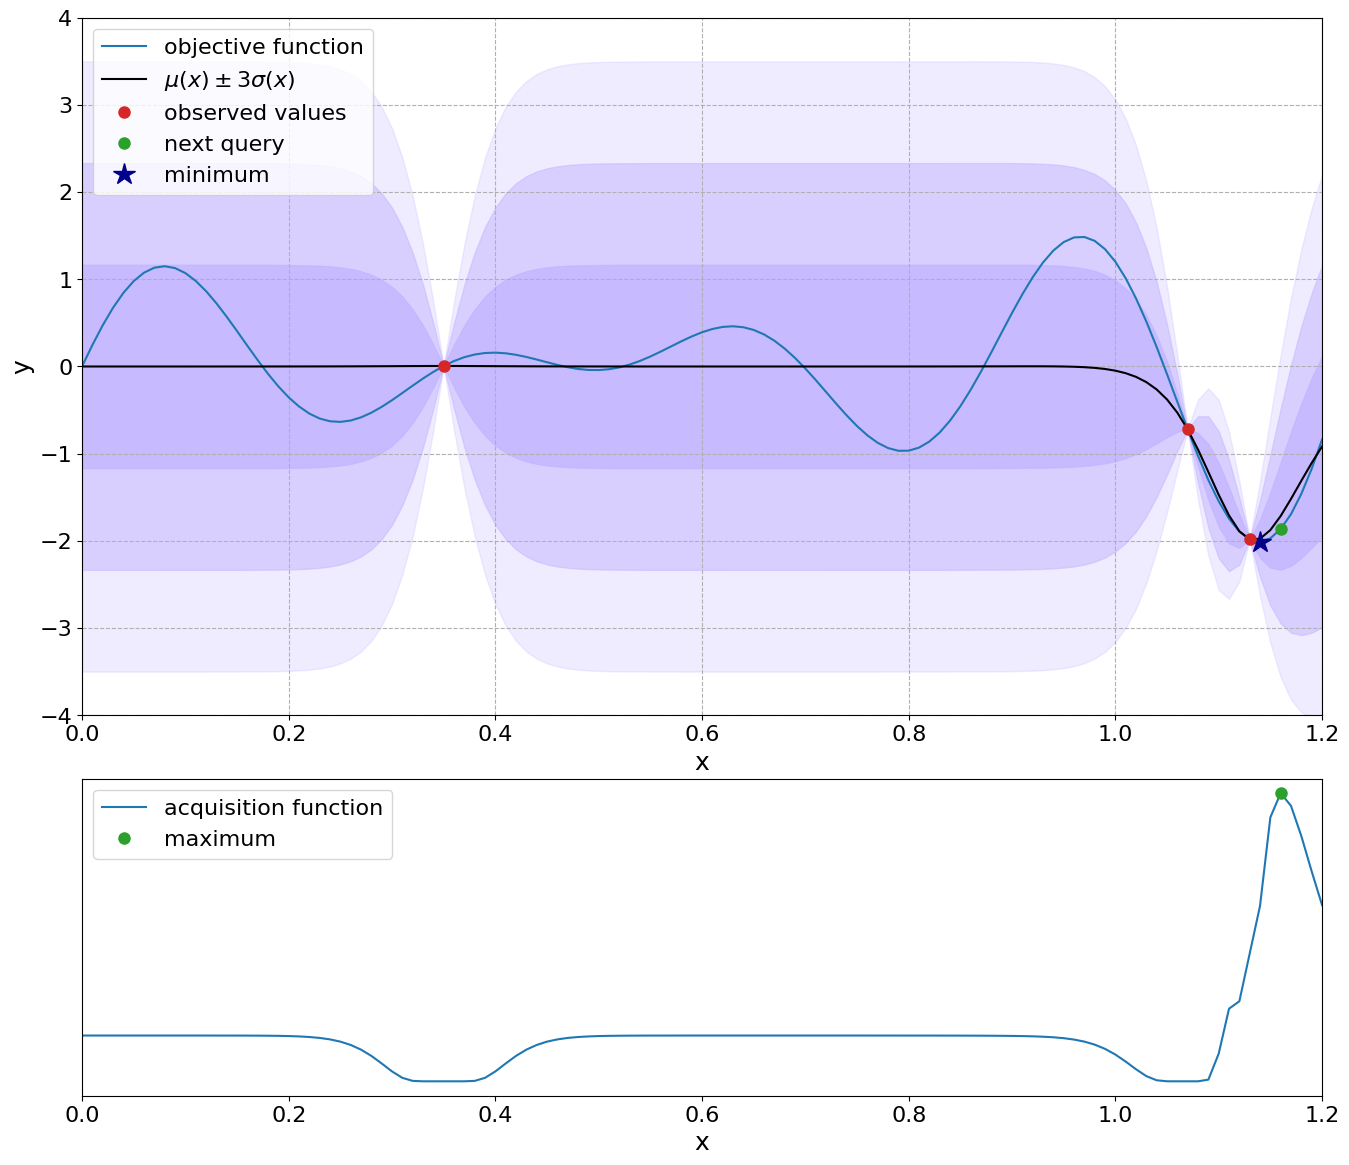

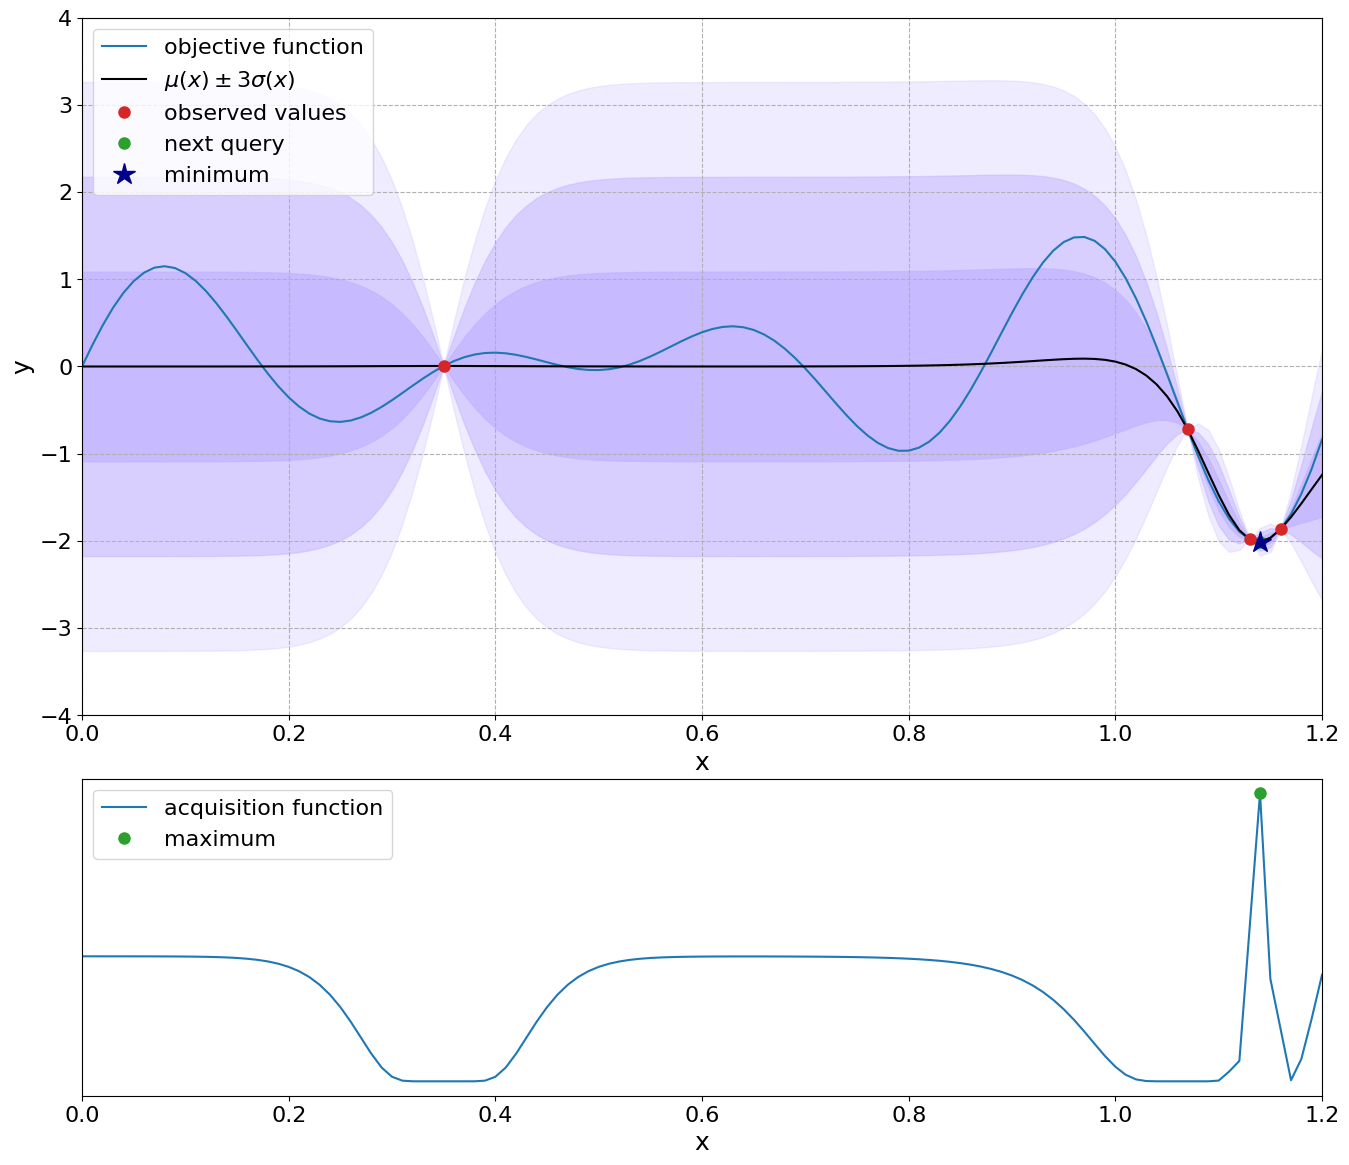

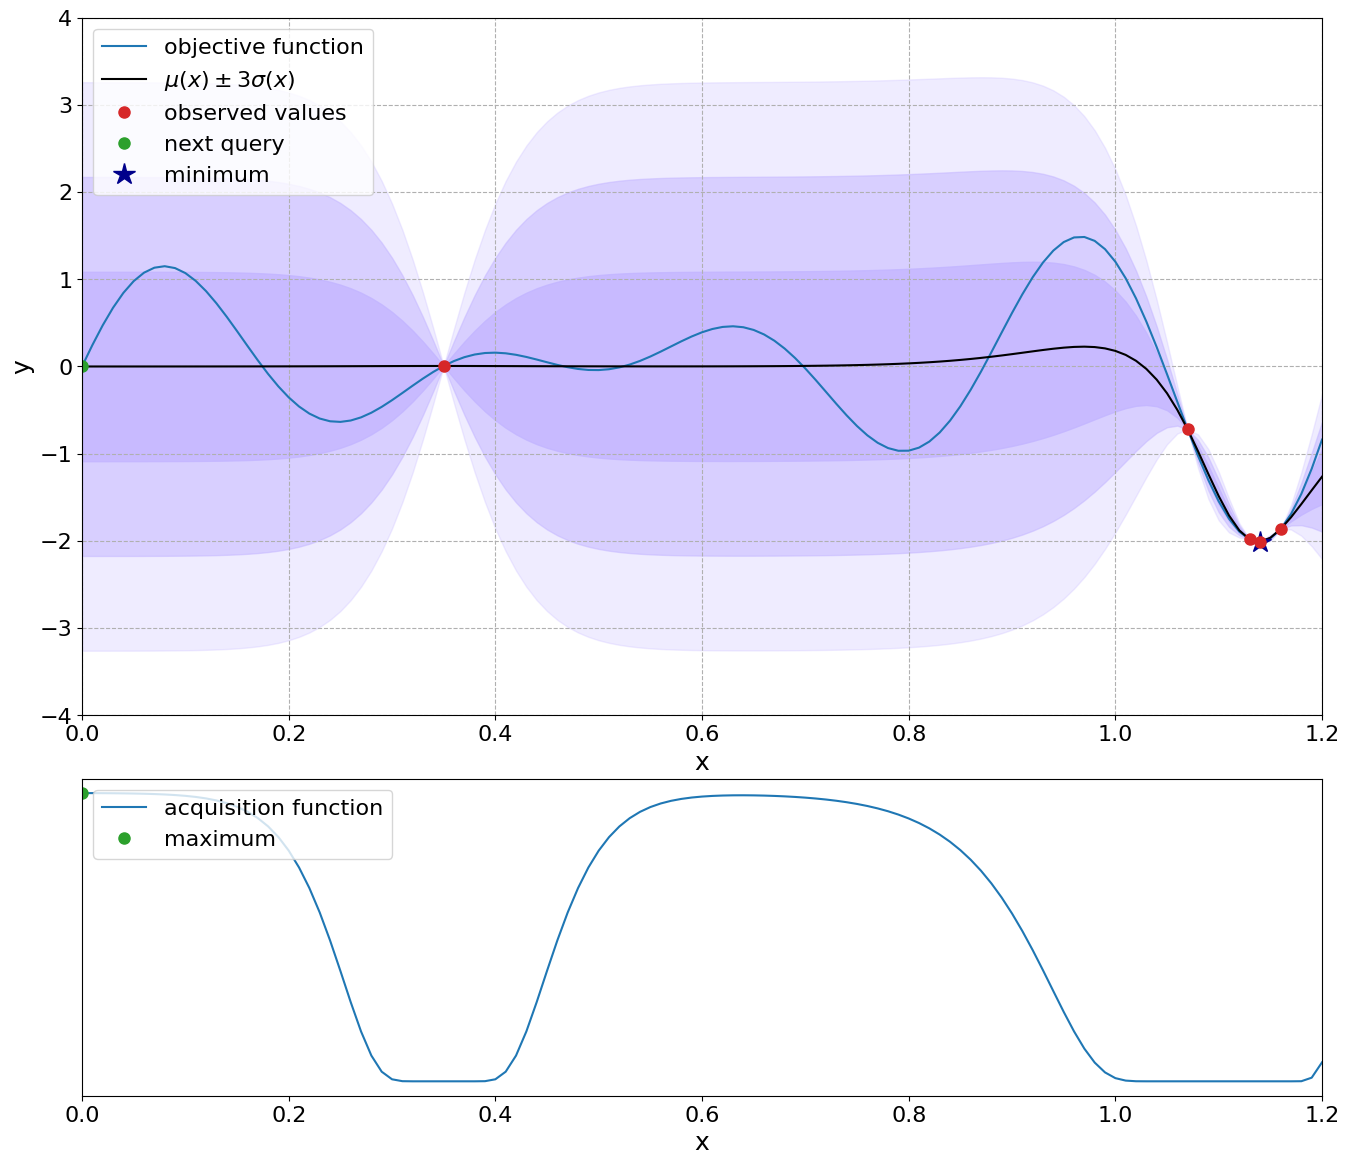

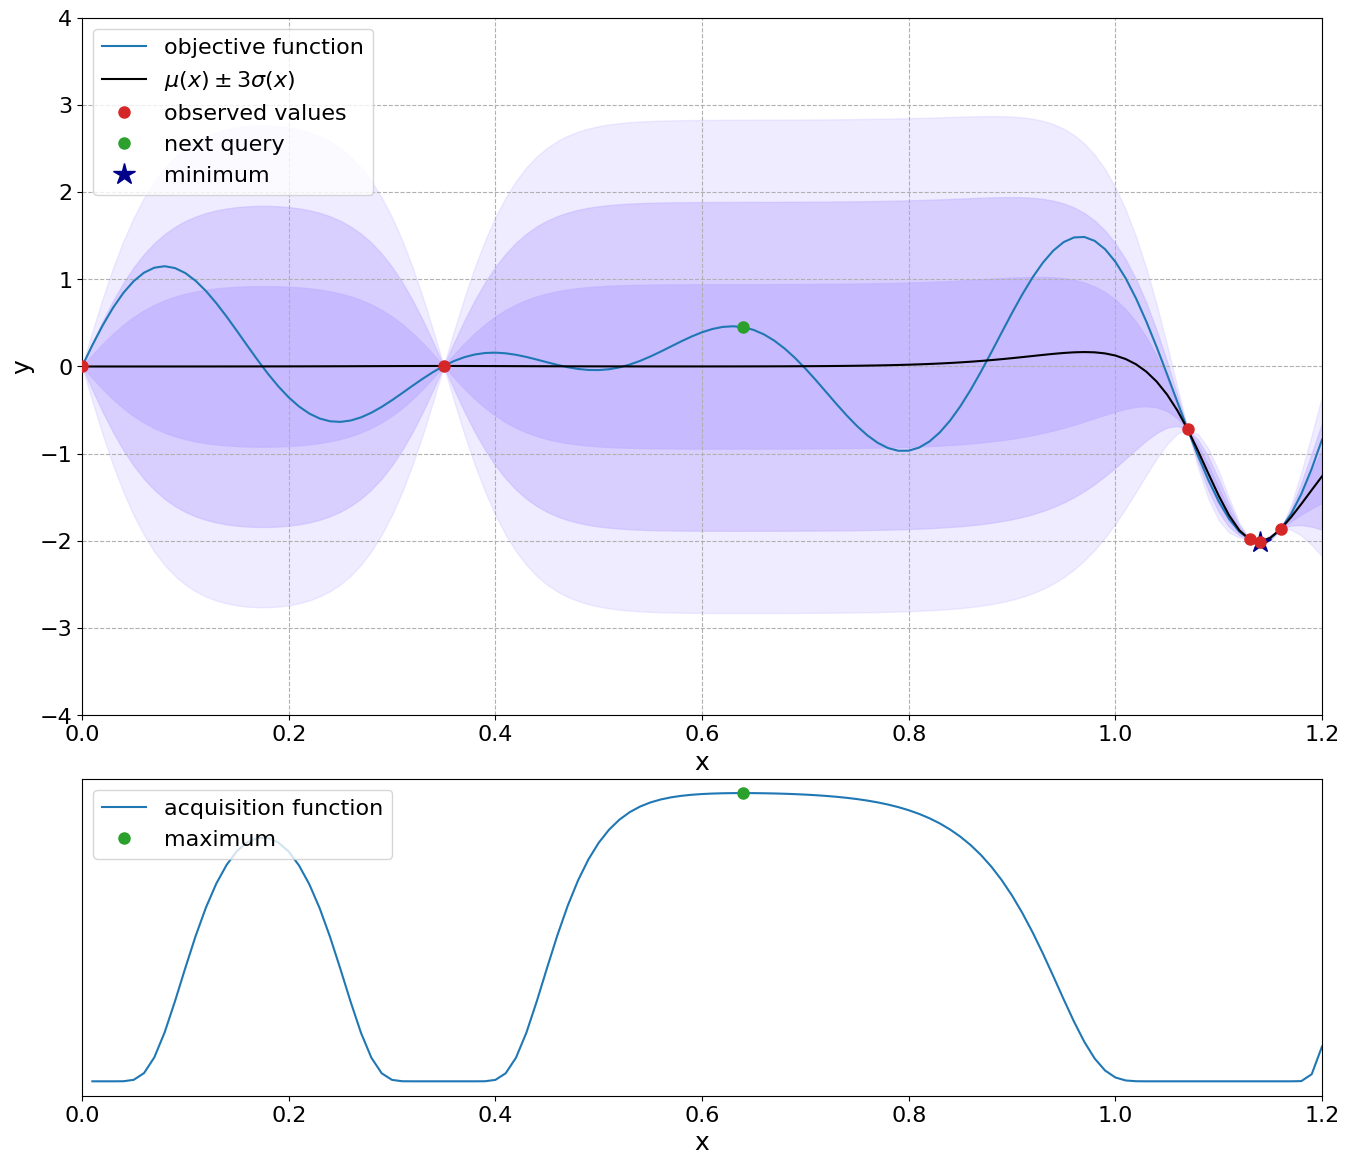

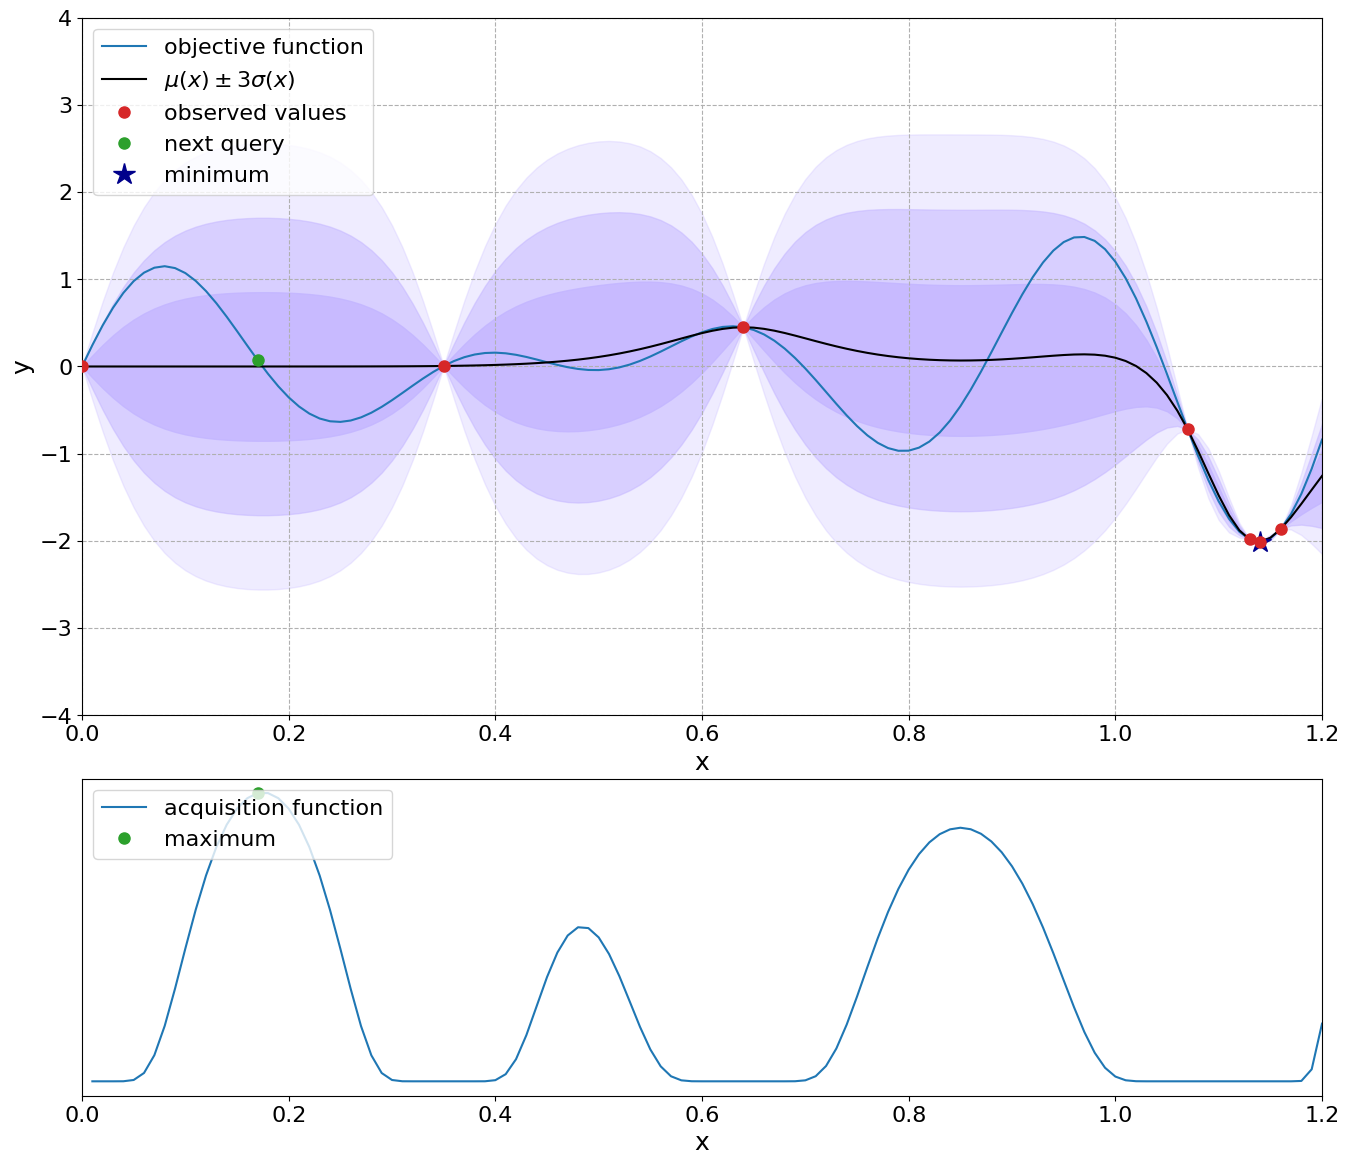

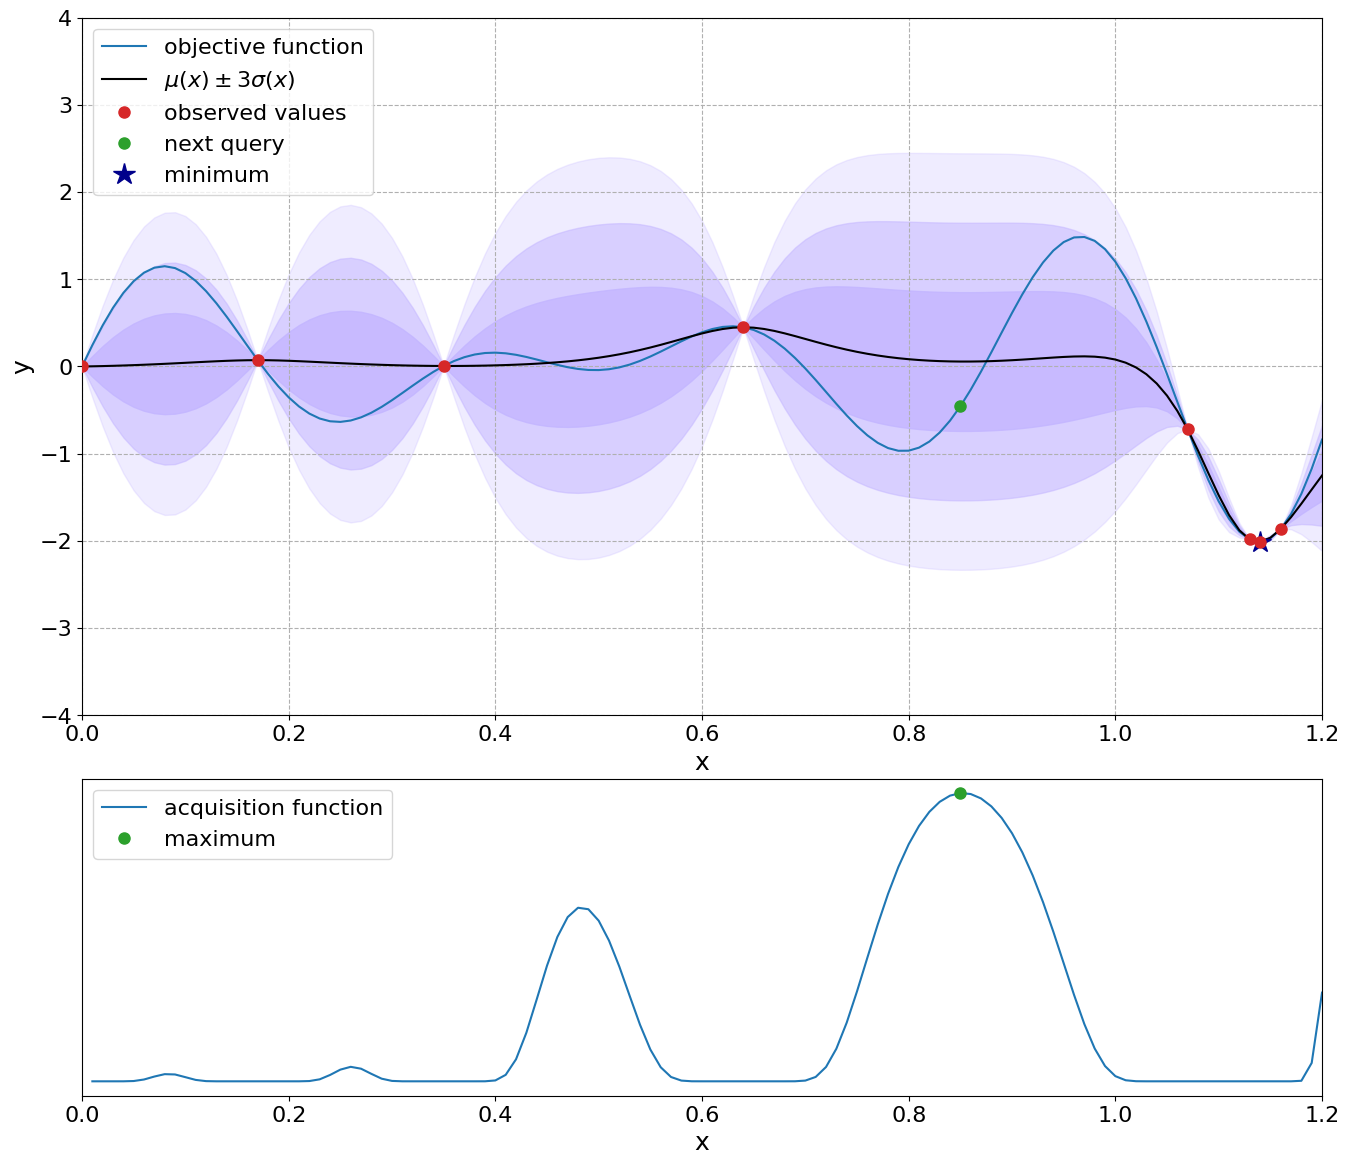

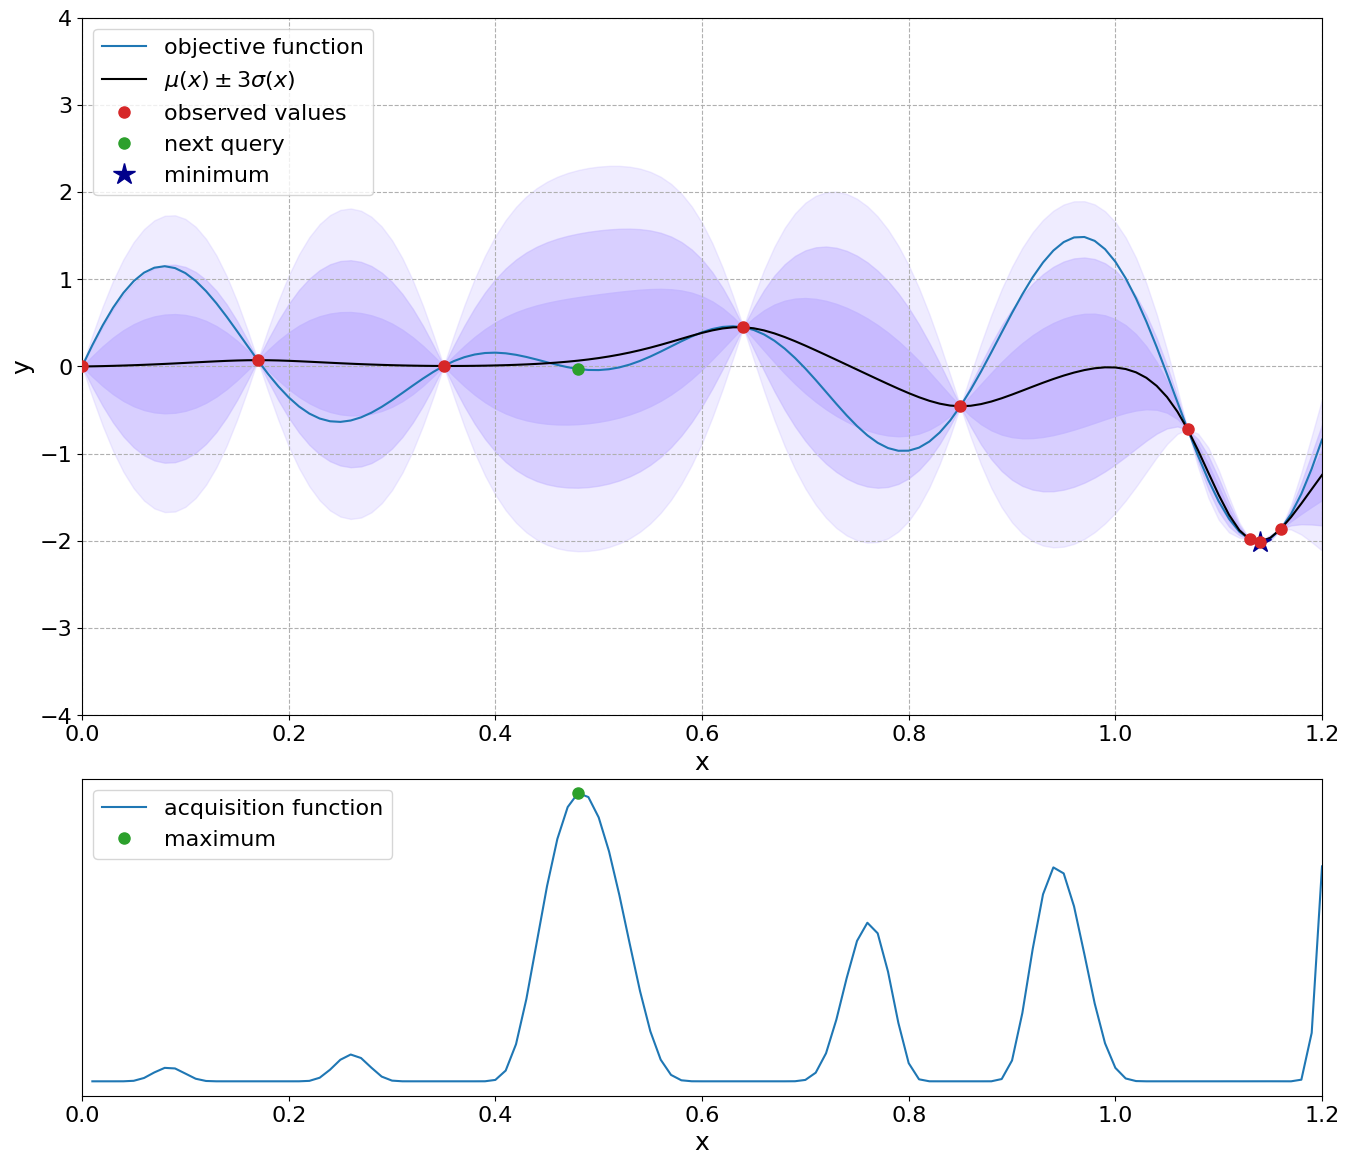

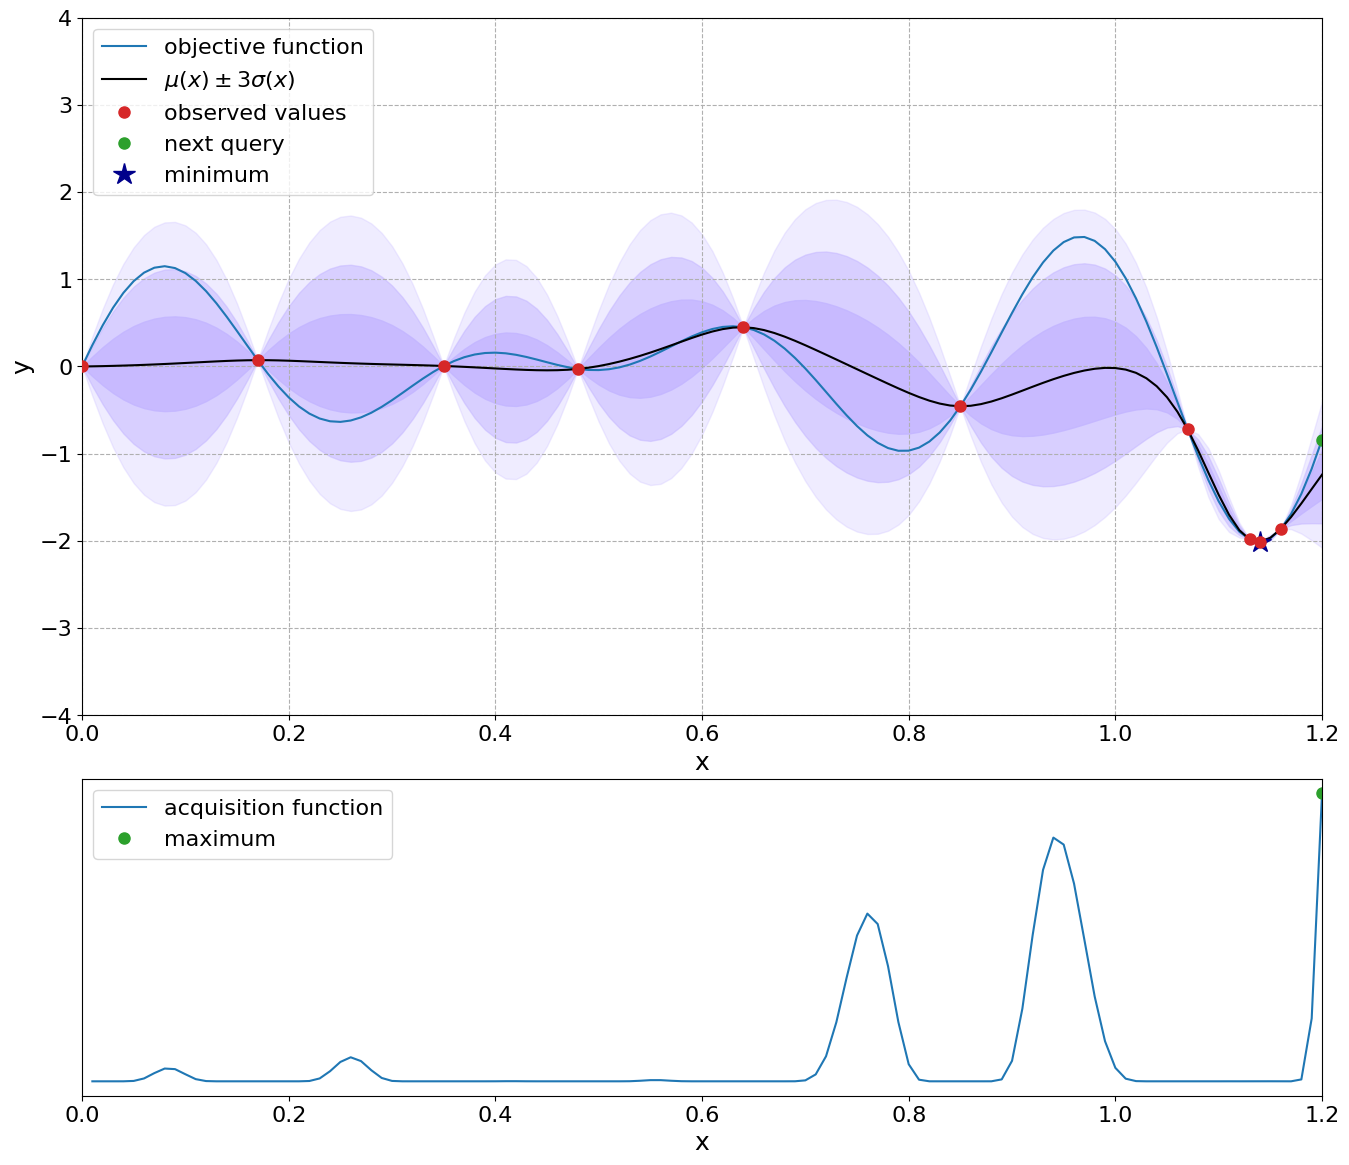

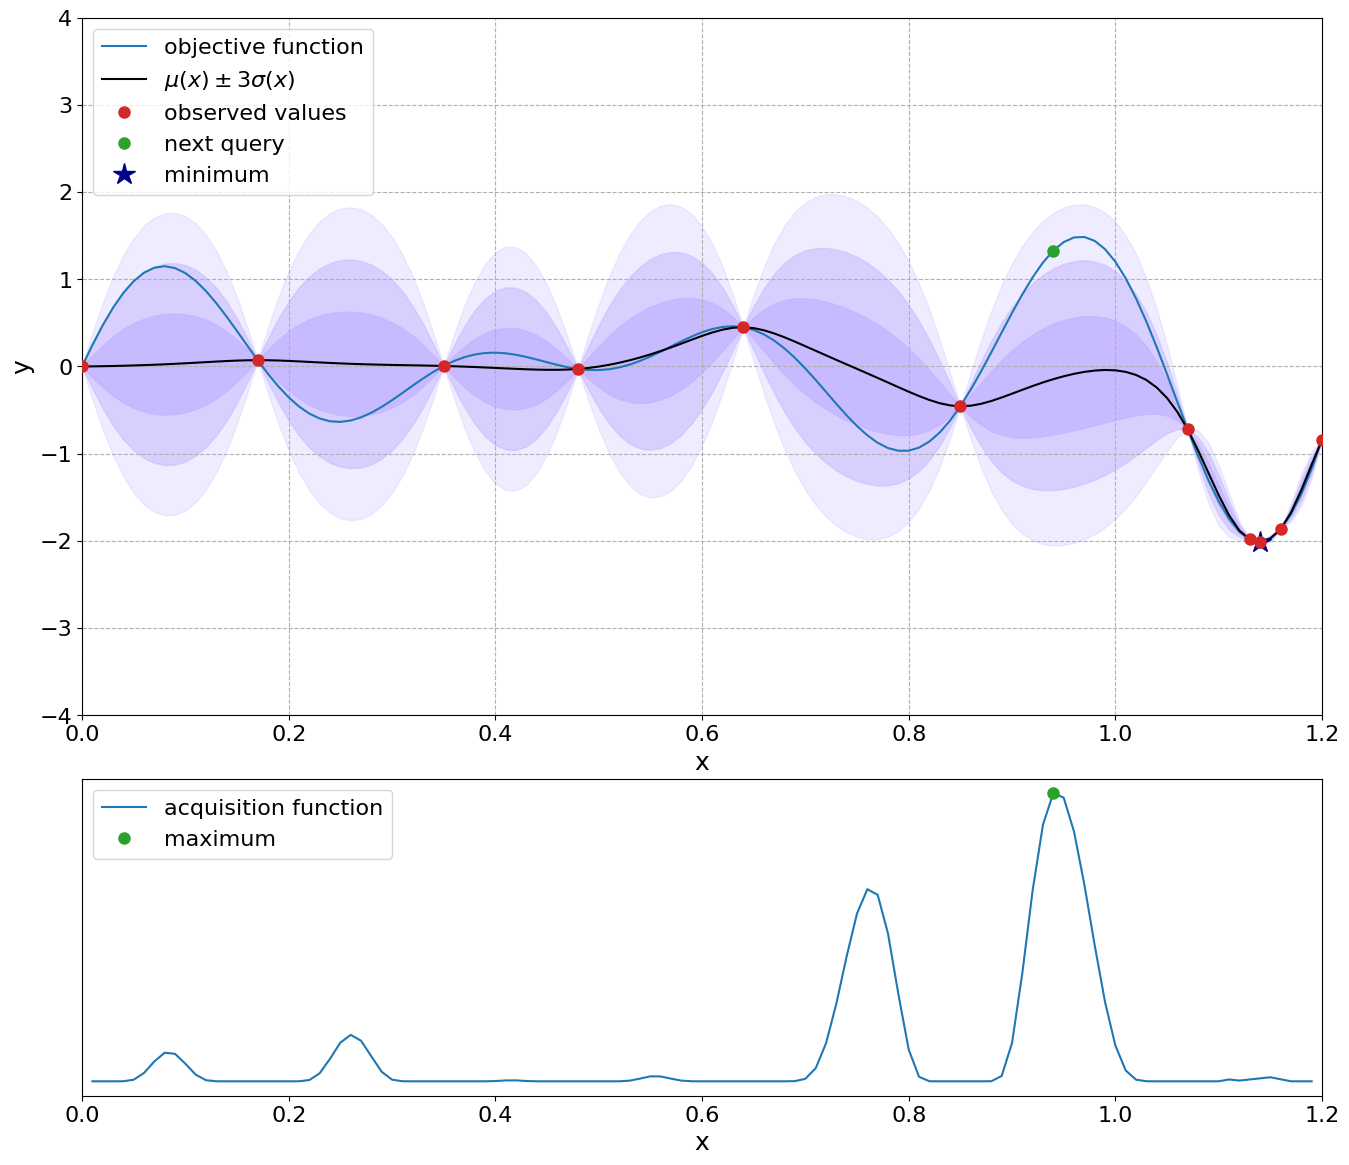

In [ ]:
n_std = 3

for i in range(len(BO.X_log)):

    # plot
    fig = plt.figure(figsize=(16,14))

    ## --------- ##
    ## posterior ##
    ## --------- ##

    plt.subplot(3,1,(1,2))

    # objective function, posterior mean, observed points and next query
    data = {
        "x": np.append(BO.Xs_log[i][:,0], BO.X_log[i][:-1,0]),
        "obj": np.append(obj_func_1D(BO.Xs_log[i][:,0]), BO.Y_log[i][:-1]),
        "mu": np.append(BO.mu_log[i], BO.Y_log[i][:-1])
    }

    df = pd.DataFrame.from_dict(data)
    df = df.sort_values("x")

    plt.plot(df.x, -df.obj, color="tab:blue", label="objective function")
    plt.plot(df.x, -df.mu, color="k", label=f"$\mu(x) \pm {n_std}\sigma(x)$", zorder=2)
    plt.plot(BO.X_log[i][:-1,0], -BO.Y_log[i][:-1], color="tab:red", marker=".", ls="", ms=16, label="observed values", zorder=3)
    plt.plot(BO.X_log[i][-1,0], -BO.Y_log[i][-1], color="tab:green", marker=".", ls="", ms=16, label="next query")
    plt.plot(x_tot[obj_func_1D(x_tot).argmax()],- np.max(obj_func_1D(x_tot)), color="darkblue", marker="*", ls="", ms=16, label="minimum")


    # posterior covariance matrix
    std = np.sqrt(np.diagonal(BO.Sigma_log[i]))

    for n in range(n_std):

        data_std = {
            "x": np.append(BO.Xs_log[i][:,0], BO.X_log[i][:-1,0]),
            "low": np.append(-BO.mu_log[i] + (n+1)*std, -BO.Y_log[i][:-1]),
            "high": np.append(-BO.mu_log[i] - (n+1)*std, -BO.Y_log[i][:-1])
        }

        df_std = pd.DataFrame.from_dict(data_std)
        df_std = df_std.sort_values("x")
        plt.fill_between(df_std.x, df_std.low, df_std.high, color='#c3b5ff', alpha=1-(n+1)*0.25, zorder=1)

    plt.xlim((0, 1.2))
    plt.ylim((-4, 4))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("x", fontsize=18)
    plt.ylabel("y", fontsize=18)
    plt.legend(loc="upper left", fontsize=16)
    #plt.legend(loc="center left", fontsize=16, bbox_to_anchor=(1.0, 0.5))
    plt.grid(ls="--")

    ## ----------- ##
    ## acquisition ##
    ## ----------- ##

    plt.subplot(3,1,3)
    plt.plot(BO.Xs_log[i][:,0], BO.alpha_log[i], color="tab:blue", label="acquisition function") #r"$\alpha_{\mathrm{" + acquisition + "}}$")

    maximum = BO.Xs_log[i][np.argmax(BO.alpha_log[i]),0]
    plt.plot(maximum, np.max(BO.alpha_log[i]), color="tab:green", marker=".", ls="", ms=16, label="maximum")

    plt.xlim((0, 1.2))
    plt.xticks(fontsize=16)
    plt.yticks([], fontsize=16)
    plt.xlabel("x", fontsize=18)
    #plt.ylabel("y", fontsize=18)
    plt.legend(loc="upper left", fontsize=16)
    #plt.legend(loc="center left", fontsize=16, bbox_to_anchor=(1.0, 0.5))
    #plt.grid(ls="--")

    #fig.subplots_adjust(right=0.65)

    plt.savefig(DIR_PATH + f"/{i:003}.png")


## GIF

In [ ]:
# collect images names
images = []
for filename in os.listdir(DIR_PATH):
    if filename.endswith(".png"):  # filter for files with a specific extension
        images.append(os.path.join(DIR_PATH, filename))
images.sort()

# create the frames
frames = [PIL.Image.open(img) for img in images]

# save into a GIF file that loops forever
frames[0].save("BO_1D.gif", format="GIF",
               append_images=frames[1:],
               save_all=True,
               duration=1000, loop=0)

## IPython

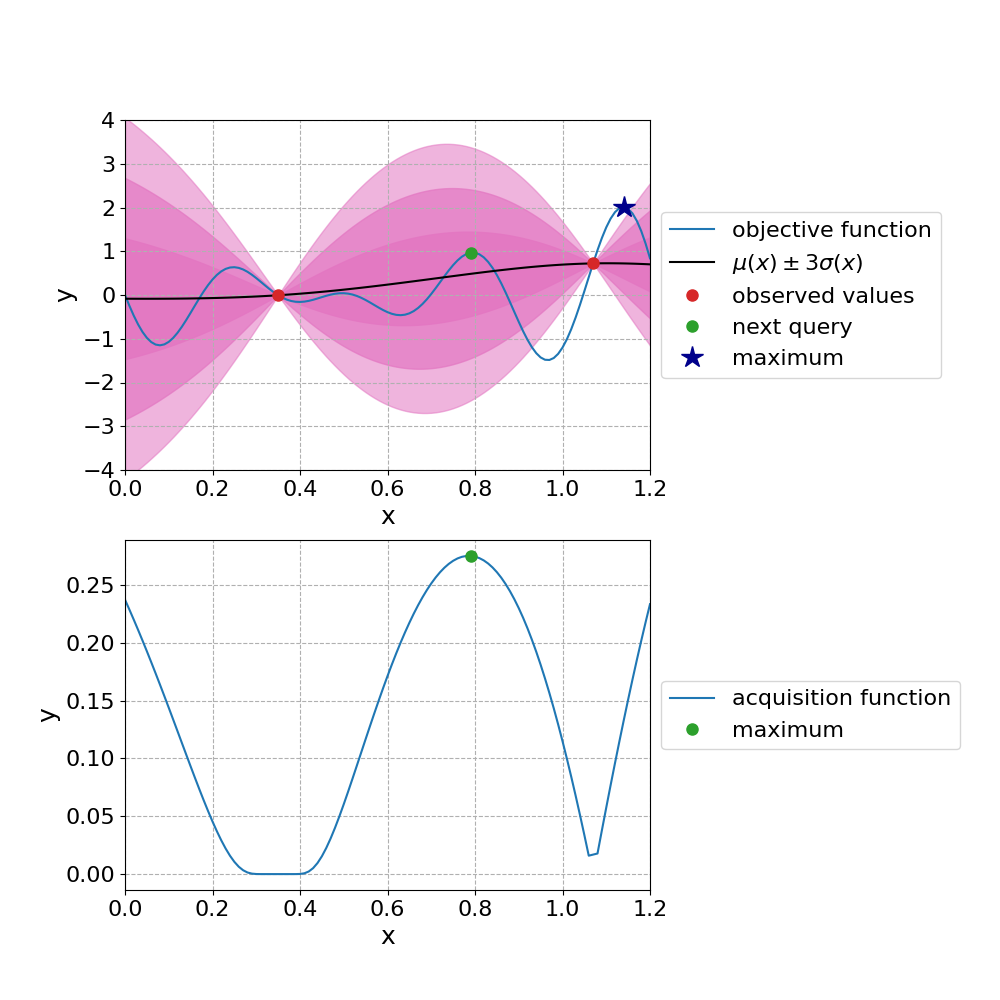

Button(description='Next Point', style=ButtonStyle())

In [ ]:
# initialize the image index
img_index = 0

# function to display the current image
def show_image():
    global img_index
    img = Image(filename=images[img_index])
    clear_output(wait=True)  # clear the output before displaying the new image
    display(img)

# function to handle button clicks
def on_button_clicked(b):
    global img_index
    img_index += 1
    if img_index >= len(images):
        img_index = 0
    try:
        show_image()
    except Exception as e:
        print(e)
    display(button)

# create the button and display the first image
button = widgets.Button(description="Next Point")
button.on_click(on_button_clicked)
show_image()

# display the button
display(button)

## Comparison

In [ ]:
# plot average comparison of different choice of method and hyperparameter (specified in the dictionary BO_dict)

def comparison(n_iteration, starting_points = 2, x_tot=x_tot, obj_func = obj_func_1D,
               seed = 84673762, n_query = 15, RandomSearch = True,
               BO_dict = {'var': [0], 'kernel':['matern_5'], 'theta':[np.array([2,0.5])],
                          'tuning' : [{"method": "MLE", "bounds" : None}, {"method": "off"}, {'method':'GD', 'epochs':10, 'lr':0.0001}],
                          'aquisition' : [{"method": "EI", "tradeoff": 0.005}]},
               marginalize_acq = {"status": False, "num_samples": 1000, "num_burns": 300, "thinning": 5, "std": 1}):

    verbose = False

    # set random seed
    np.random.seed(seed)

    if marginalize_acq.get('status') == True:
        BO_dict['tuning'].append({"method": "MAP"})

    # list of all possible combinations of elements in BO_dict
    BO_param_combination = list(itertools.product(*BO_dict.values()))



    # array of the cummulative maximum for each method and for each iteration
    cummax_log = np.zeros((n_iteration, n_query + starting_points, len(BO_param_combination)+ RandomSearch + marginalize_acq.get('status')))



    for i in range(n_iteration):



        # observed locations and values
        idx = np.random.choice(np.arange(x_tot.shape[0]), size=starting_points, replace=False)
        x = x_tot[idx]
        y = obj_func(x)


        X = x.reshape(-1,1)
        #print(X, '\n')
        Y = y


        # test locations
        xs = np.delete(x_tot, idx)
        Xs = xs.reshape(-1,1)

        print('\n Iteration: ', i)


        # Bayesian Optimization

        for p in range(len(BO_param_combination)):

            # Bayesian Optimization for each combinations of elements in BO_dict
            BO_param = BO_param_combination[p]
            #print('\n', BO_param)


            if BO_param[3] == {"method": "MAP"}:
                BO = BayesianOptimization(X, Y, Xs,
                          BO_param[0], BO_param[1], BO_param[2], {"method": "off"},
                          obj_func, BO_param[4], marginalize_acq, n_query, verbose)

            else:
                BO = BayesianOptimization(X, Y, Xs,
                                          BO_param[0], BO_param[1], BO_param[2], BO_param[3],
                                          obj_func, BO_param[4], {'status': False}, n_query, verbose)

            #print( BO_param[0], BO_param[1], BO_param[2], BO_param[3], obj_func, BO_param[4], {'status': False}, n_query, verbose)

            BO.Bayesian_search()

            # evaluate the cummulative maximum
            cummax_log[i,:, p] = list(itertools.accumulate(BO.Y, max))




        # Random Grid Search

        if RandomSearch:
            # Random Grid Search
            RS = RandomGridSearch(X, Y, Xs, obj_func, n_query, verbose)
            RS.random_search()

            # evaluate the cummulative maximum
            cummax_log[i,:, -1] = list(itertools.accumulate(RS.Y, max))







    # Plot

    # mean
    cummax_mean = np.mean(cummax_log, axis=0)
    # error of the mean
    cummax_std_mean = np.std(cummax_log, axis=0)/np.sqrt(n_iteration)

    iterations = np.arange(n_query+starting_points)

    # list of indexes of BO_dict with more than one value
    comparison_param_ind =[i for i, key in enumerate(BO_dict.keys()) if len(BO_dict[key]) > 1]

    fig, ax = plt.subplots(figsize=(16,7))


    # Random Search
    if RandomSearch:
        ax.errorbar(iterations, cummax_mean[:,-1],
                    cummax_std_mean[:,-1], label='Random Search',
                   fmt='o', ls='--')


    # Bayesian Optimization
    for l in range(len(BO_param_combination)):

        # label reporting only BO_dict elements with more than one value
        label = 'BO: '
        for m in comparison_param_ind:

            if list(BO_dict.keys())[m] == 'tuning':
                label += 'tuning' + ' = ' + BO_param_combination[l][m].get('method')

            elif list(BO_dict.keys())[m] == 'aquisition':
                label += BO_param_combination[l][m].get('method') + ' tradeoff' + ' = ' + str(BO_param_combination[l][m].get('tradeoff'))


            else:
                label += list(BO_dict.keys())[m] + ' = ' + str(BO_param_combination[l][m])

            if m != comparison_param_ind[-1]: label += ', '

        ax.errorbar(iterations, cummax_mean[:,l],
                    cummax_std_mean[:,l], label=label,
                   fmt='o', ls='--')

        ax.legend(loc = 'lower right', fontsize=16)
        ax.grid(ls='--')
        ax.set_xlabel('function evaluations', fontsize=18)
        ax.set_ylabel('max function value', fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax.set_title('Methods comparison', fontsize=18)


 Iteration:  0
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  1
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  2
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  3
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  4
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  5
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  6
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  7
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search star

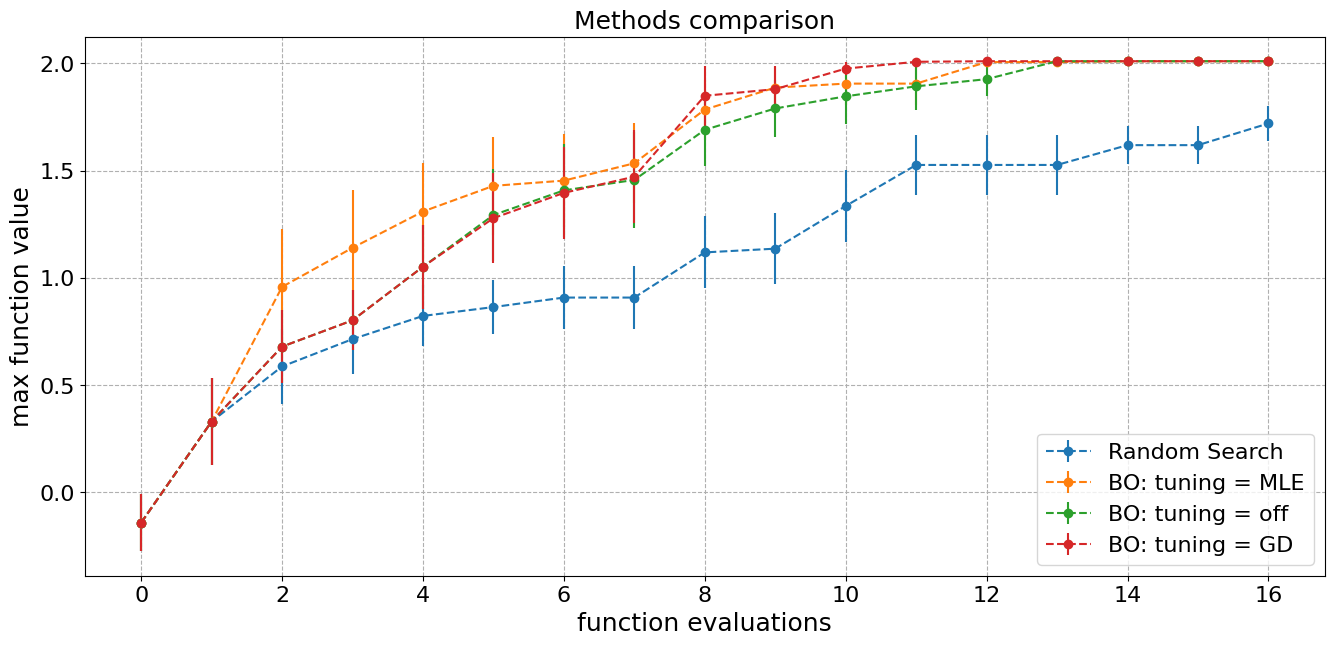

In [ ]:
comparison(10)


 Iteration:  0
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  1
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  2
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  3
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  4
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  5
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  6
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  7
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search star

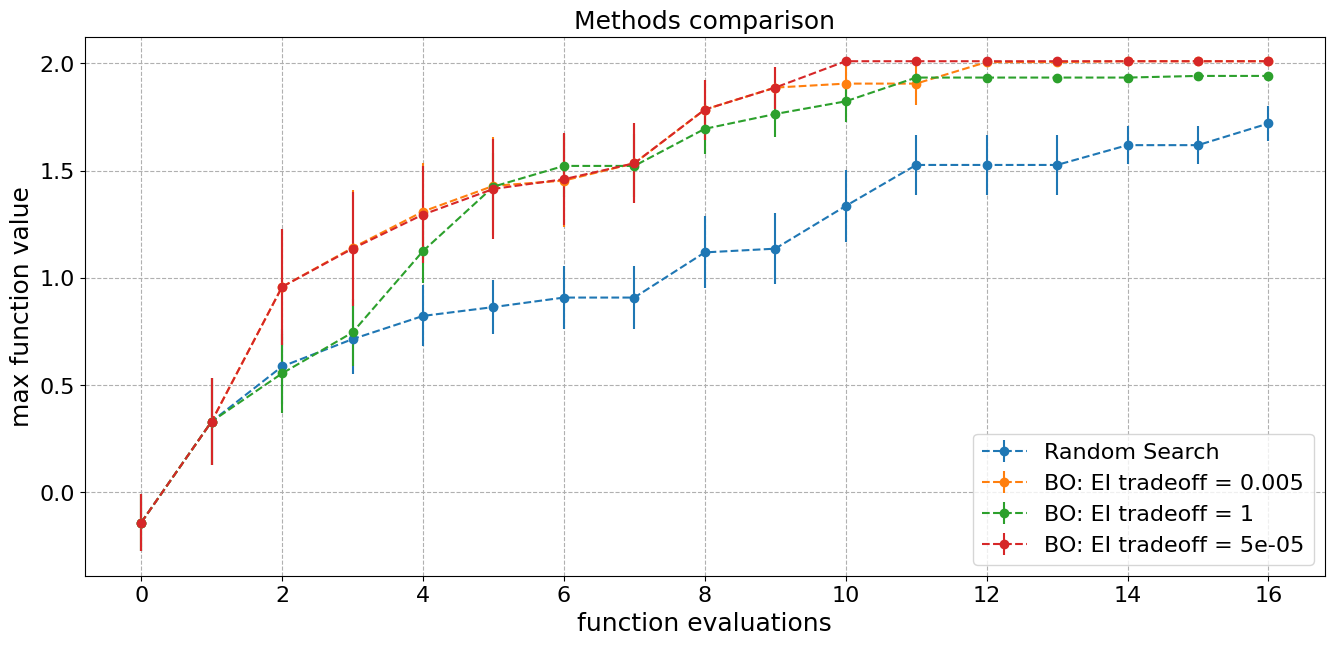

In [ ]:
comparison(n_iteration=10, starting_points = 2, x_tot=x_tot, obj_func = obj_func_1D,
               seed = 84673762, n_query = 15, RandomSearch = True,
               BO_dict = {'var': [0], 'kernel':['matern_5'], 'theta':[np.array([2,0.5])],
                          'tuning' : [{"method": "MLE"}],
                          'aquisition' : [{"method": "EI", "tradeoff": 0.005}, {"method": "EI", "tradeoff": 1}, {"method": "EI", "tradeoff": 0.00005}]},
               marginalize_acq = {"status": False, "num_samples": 1000, "num_burns": 300, "thinning": 5, "std": 1})